In [5]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "/content/drive/My Drive/Colab Notebooks/Facial sentiment analysis/second_model"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Facial sentiment analysis/second_model


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, os, io
import cv2
from zipfile import ZipFile
from PIL import Image

## 1.2 Getting the dataset ready

In [ ]:
shock_zip = ZipFile("shock.zip", "r")
happy_zip = ZipFile("happy.zip", "r")
sad_zip = ZipFile("sad.zip", "r")
neutral_zip = ZipFile("neutral.zip", "r")

In [ ]:
shock_img = []
happy_img = []
sad_img = []
neutral_img = []
for var_zip, var_img in zip((shock_zip, happy_zip, sad_zip, neutral_zip), 
                            (shock_img, happy_img, sad_img, neutral_img)):
    for img_name in var_zip.namelist():
        byte_data = var_zip.read(img_name)
        img = io.BytesIO(byte_data)
        img = np.array(Image.open(img))
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, code=6) if len(img.shape) == 3 else img    #note
        var_img.append(img)
shock_img = np.asarray(shock_img)
happy_img = np.asarray(happy_img)
sad_img = np.asarray(sad_img)
neutral_img = np.asarray(neutral_img)

***
## 1.3 Train & Test Set

Now we have 1180 images (180 original, 1000 generated) for each category. Everything else is the same.

In [ ]:
X_train = np.concatenate([neutral_img, sad_img, shock_img, happy_img], axis=0)
y_train = np.array([0]*1180 + [1]*1180 + [2]*1180 + [3]*1180)

# 20% (944) of the pictures will be chosen for the test set
# first we get the random indices:
random_num_neutral = np.random.choice(range(0, 1180), 236, replace=False)
random_num_sad = np.random.choice(range(1180, 2360), 236, replace=False)
random_num_shock = np.random.choice(range(2360, 3540), 236, replace=False)
random_num_happy = np.random.choice(range(3540, 4720), 236, replace=False)
random_indices = np.concatenate([random_num_neutral, 
                                 random_num_sad,
                                 random_num_shock,
                                 random_num_happy])
# The test set is almost ready:
X_test = X_train[random_indices]
y_test = y_train[random_indices]
# let's remove the selected pictures from the train set:
X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

# Do not forget to shuffle the set:
def shuffle_set():
    # to make sure the shuffle is the same for both of them,
    random_state = np.random.get_state()
    np.random.shuffle(X_train)
    np.random.shuffle(X_test)
    # we keep the random state and pass it to the next step:
    np.random.set_state(random_state)
    np.random.shuffle(y_train)
    np.random.shuffle(y_test)
shuffle_set()

# ...and we dispose of these temporary tools:
del (random_num_neutral, random_num_sad, random_num_shock, 
     random_num_happy, random_indices, shuffle_set)

## 1.4 Image Generation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img

In [ ]:
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [ ]:
# now we don't need to modify any images. let's just normalize them:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=16, 
                                     shuffle=True,
                                     subset="training",
                                     )
validation_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=16, 
                                     shuffle=True,
                                     subset="validation",
                                     )
test_generator = test_datagen.flow(x=X_test, y=y_test, 
                                     batch_size=4, 
                                     shuffle=True, 
                                     )

In [ ]:
# This block was used to generate and save images BEFORE this notebook was,
# prepared but I though it's better to have this block here.

# gen_folder = "./gen_happy"    # example of generated "happy" faces
# gen_img = happy_img[..., np.newaxis]    # remember: 4D tensor is needed.

# os.mkdir(gen_folder)

# train_generator = train_datagen.flow(x=gen_img,
#                                     batch_size=1, 
#                                     shuffle=True,
#                                     save_to_dir=(gen_folder), 
#                                     save_prefix="", 
#                                     save_format="jpg", 
#                                     seed=None,
#                                     )
# for i, picture in enumerate(train_generator):
#     if i == 999:    # 1000 more images were generated
#         break

# 2\. Creating The Model

## 2.1 Shape of The Dataset

In [ ]:
from keras import models, layers

In [ ]:
print("---Shape of the train set---\nX_train:", X_train.shape, 
      "\ny_train:", y_train.shape)
print("\n---Shape of the test set---\nX_test:", X_test.shape, 
      "\ny_test:", y_test.shape)

---Shape of the train set---
X_train: (3776, 64, 64, 1) 
y_train: (3776,)

---Shape of the test set---
X_test: (944, 64, 64, 1) 
y_test: (944,)


## 2.2 Neural Network Models

### 2.2.0 TensorBoard Configuration & Monitoring

In [1]:
from keras.callbacks import TensorBoard
from tensorboard import notebook as tb_notebook

In [2]:
# Load the TensorBoard notebook extension:
%load_ext tensorboard

#### \>>> TensorBoard

In [ ]:
# To run the TensorBoard:
%tensorboard --logdir my_log_dir

TensorBoard snippet of the generated images' models.

 ![TensorBoard Snippet](https://i.pinimg.com/originals/ed/7d/24/ed7d24dff50e7254c1a0b790fcacd878.jpg)

### 2.2.1 Model 1

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        padding="same", 
                        kernel_size=(3, 3), 
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.50))

model.add(layers.Conv2D(filters=64, 
                        padding="same",
                        activation="relu",
                        kernel_size=(3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.50))

model.add(layers.Conv2D(filters=128, 
                        padding="same",
                        activation="relu",
                        kernel_size=(3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.50))

model.add(layers.Flatten())
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(4, activation="softmax", name="Output_Layer"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)       

In [ ]:
def compile_model(model_number="(null)", epochs=20):
    model.compile(optimizer="adam", 
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
    # TensorBoard configuration:
    # create a folder for log files
    my_log_dir = os.path.join("my_log_dir", 
                        datetime.datetime.now().strftime("%Y-%m-%d_%H.%M.%S" + 
                                                         model_number))
    tensorboard_callbacks = TensorBoard(log_dir=my_log_dir,
                                        histogram_freq=1)
    # fit the set:
    model_history = model.fit(train_generator, 
                    batch_size=16, 
                    epochs=epochs, 
                    verbose=0, 
                    validation_data=validation_generator,
                    callbacks=[tensorboard_callbacks]
                    )
    return model_history

In [ ]:
model_history = compile_model("(1)")

In [ ]:
# cosmetic configuration
def display_graph(model_number="(null)"):
    sns.set(style="whitegrid")
    title_font = {"family":"sans", 
                "color":"darkred", 
                "size":30, 
                "weight":"bold", 
                "alpha":0.9}
    axis_font = {"family":"sans-serif", 
                "color":"black", 
                "size":16, 
                "weight":"bold"}

    # plot the graphs
    plt.figure(figsize=(20,8))
    plt.suptitle("Model: " + model_number, fontdict=title_font)
    plt.subplot(1,2,1)
    plt.plot(range(1, len(model_history.history["accuracy"])+1), 
            model_history.history["accuracy"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_accuracy"])+1), 
            model_history.history["val_accuracy"], 
            "r--", linewidth=2, label="Valdation Set", alpha=0.8)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Accuracy Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.subplot(1,2,2)
    plt.plot(range(1, len(model_history.history["loss"])+1), 
            model_history.history["loss"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_loss"])+1), 
            model_history.history["val_loss"], 
            "r--", linewidth=2, label="Validation Set", alpha=0.7)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Loss Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.show()

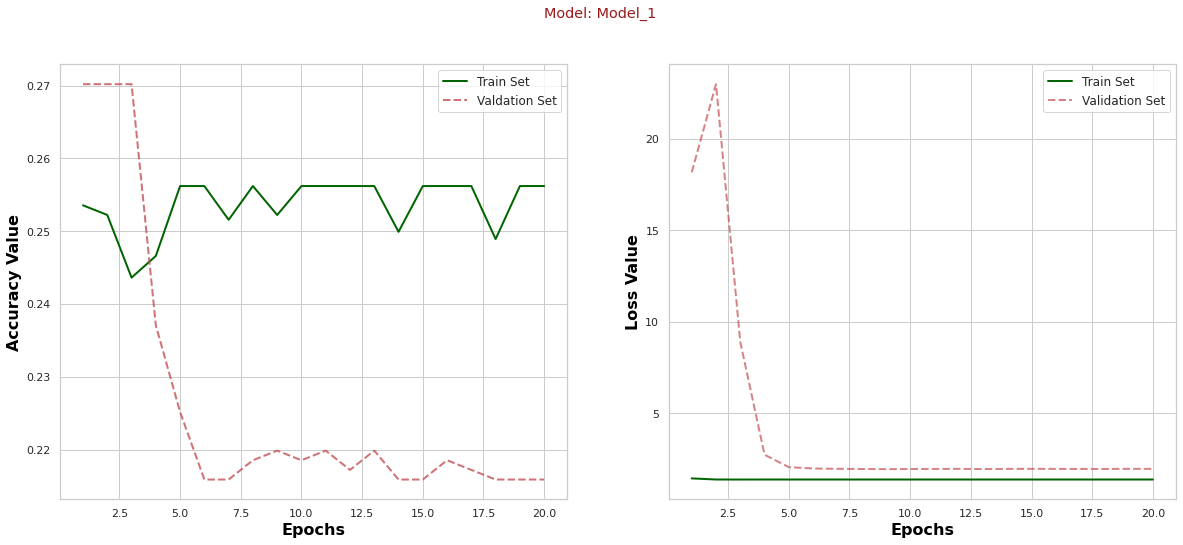

In [ ]:
display_graph("Model_1")

### 2.2.2 Model 2
We have the same story here even for 20 epochs. Since we know that we are going to do better, let me increase the epoch to 50 to see things clearer:<br>
**Changes:**<br>
* BatchNormalization --> before the non-linear (Activation) layer.
* Dropouts --> lowered
* Neurons --> decreased
* Epochs --> increased to 50

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, 
                        kernel_size=(3, 3), 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.15))

model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.15))

model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.15))

model.add(layers.Flatten())
model.add(layers.Dense(16))
model.add(layers.Activation("relu"))
model.add(layers.Dense(4, activation="softmax", name="Output_Layer"))

model_history = compile_model("(2)", epochs=50)

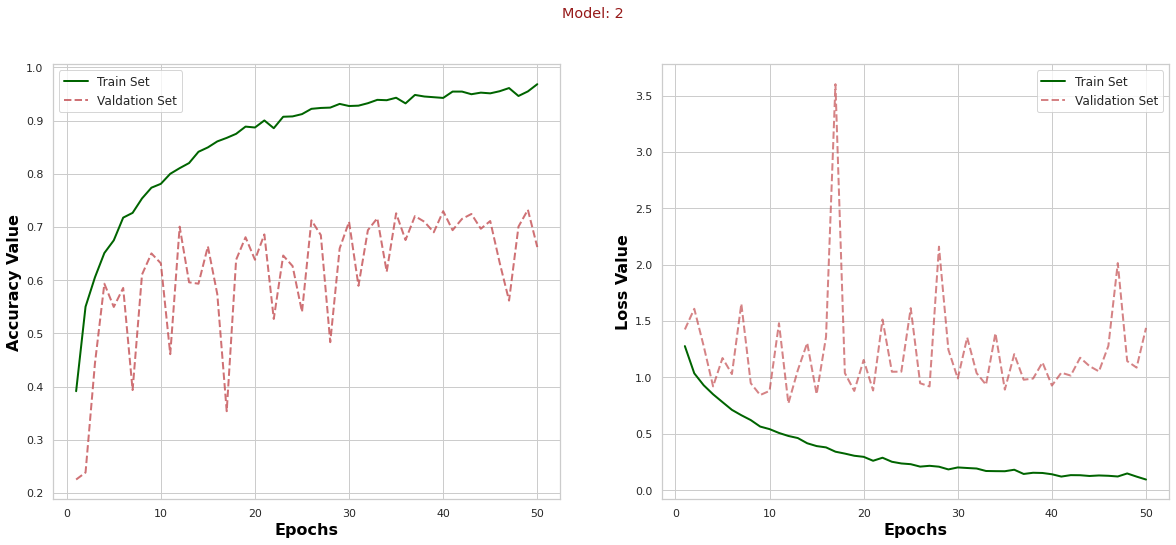

In [ ]:
display_graph("2")

In [ ]:
model.save("model2_with_1180imgs.h5")
model.evaluate(test_generator, batch_size=1)

236/236 [==============================] - 1s 3ms/step - loss: 1.3345 - accuracy: 0.6833


[1.3344982862472534, 0.6832627058029175]

### 2.2.3 Model 3
The previous model overfitted very fast. It is even worse than the one with just 180 images where it seemed to overfit after about ~50 epochs. We lost this one at  10 epochs. Generated images are the copy of each other so getting an overfit earlier is quite normal. Lose hope not! Slightly increasing dropouts and making the model simpler a bit, let's see what we get:<br>
**Changes:**<br>
* Dropouts --> slightly increased
* Layers --> lowered
* Neurons --> same
* Epochs --> same

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16, 
                        kernel_size=(3, 3), 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.35))

model.add(layers.Conv2D(filters=16, 
                        kernel_size=(3, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.35))

model.add(layers.Flatten())
model.add(layers.Dense(16))
model.add(layers.Activation("relu"))
model.add(layers.Dense(4, activation="softmax", name="Output_Layer"))

model_history = compile_model("(3)", epochs=50)

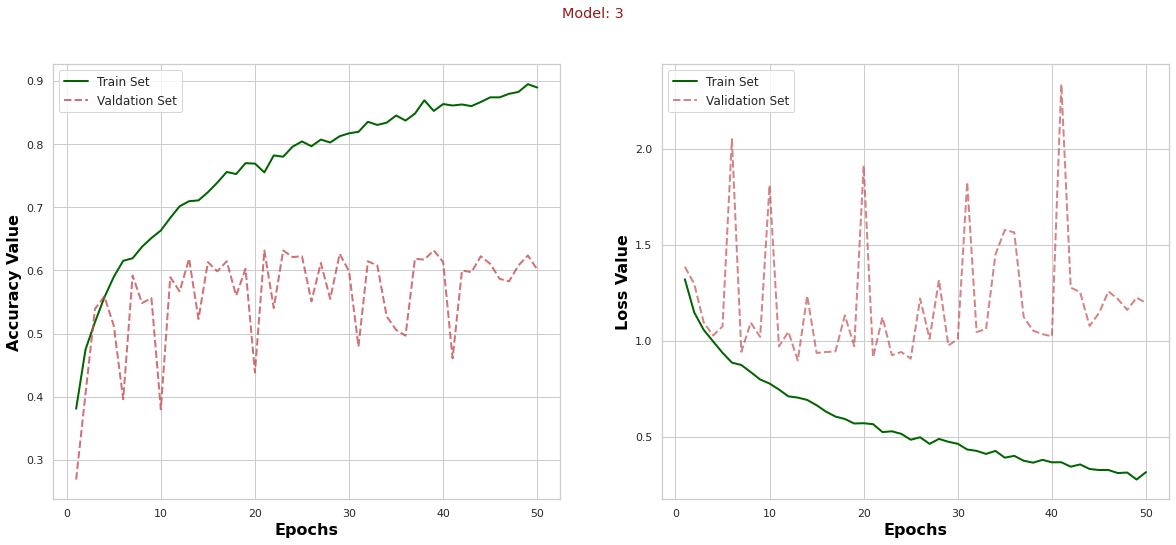

In [ ]:
display_graph("3")

In [ ]:
model.save("model3_with_1180imgs.h5")
model.evaluate(test_generator, batch_size=1)

236/236 [==============================] - 1s 3ms/step - loss: 1.0835 - accuracy: 0.6261


[1.0835254192352295, 0.6260592937469482]

Nope. It didn't work.